<img src="julia-computing.svg" width="200">

# Miletus: Pricing Analytics in Julia
### Simon Byrne, Ranjan Anantharaman
#### Julia Computing


## Background

Core problems: 
1. How do you model a financial contract?
    - There are huge variety of finanicial contracts (forwards, options, swaps, etc.), each of which can have many variations (e.g. American, European, Asian, Swing)
2. How do you determine its value?
    - Many different approaches to value them:
        - exact mathematical formulae if available (e.g. Black-Scholes)
        - lattice methods (e.g. binomial recombining trees)
        - Monte Carlo simulation



_Miletus_ is a Julia package providing:
1. a flexible contract definition language, and
2. a suite of high-performance valuation methods supporting such contracts.

Exploit many of Julia's powerful features:
- Fast and accessible user-defined types
- Generic programming and multiple dispatch
- Aggressive JIT compiler
- Composability with other libraries for features such as automatic differentiation (AD)


In [2]:
using Miletus
using Base.Dates
using Miletus.TermStructure
using Miletus.DayCounts
using BusinessDays
using Gadfly, Colors

import Miletus: When, Give, Receive, Buy, Both, At, AtObs, Either, Zero
import Miletus: YieldModel, maturitydate
import Miletus.TermStructure: ConstantContinuousYieldCurve
import BusinessDays: USGovernmentBond

## Contract Specification Language

Complex Financial contracts can be deconstructed into a set of **primitive** components. 

Inspired by the work of Simon Peyton Jones and Jean-Marc Eber: "How to write a financial contract"
- Haskell implementation based on nested combinators.

Our implementation is based on nested parametric types

**Zero** is the "null" primitive contract, which has no rights or obligations.

In [68]:
Zero()

Zero


**Receive** is a primitive contract which gives the owner a fixed amount of money.

In [6]:
# A contract where you receive 100 US dollars
a = Receive(100USD)

Amount
 └─100


**Give** reverses the obligation of the contract

In [46]:
# A contract where you owe 100 USD
Give(Receive(100USD))

Give
 └─Amount
    └─100USD


In [47]:
# Pay is shorthand for the above
Pay(100USD)

Give
 └─Amount
    └─100USD


**SingleStock** represents an arbitrary asset

In [10]:
s = SingleStock()

SingleStock


**Both** is a primitive which inherits the rights and obligations of 2 contracts.

In [48]:
# A contract to purchase SingleStock for 100 USD
Both(SingleStock(), Pay(100USD))

Both
 ├─SingleStock
 └─Give
    └─Amount
       └─100USD


In [17]:
# Buy is a shorthand form
b = Buy(s, 100USD)

Both
 ├─SingleStock
 └─Give
    └─Amount
       └─100USD


In [18]:
# the structure of the object matches that of the contract
typeof(b)

Miletus.Both{Miletus.SingleStock,Miletus.Give{Miletus.Amount{Miletus.ConstObs{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Int64}}}}}

**When** is a primitive in which the holder aquires the nested contract when the predicate condition becomes true.

A zero coupon bond is a contract to receive a single payment at some future date.

In [13]:
# Zero coupon bond - when the date is 25th December 2017, get 100 USD
ZCB(Date("2017-12-25"), 100USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Amount
    └─100USD


In [50]:
# A forward contract: agreement to purchase an asset for a fixed price at a future date.
When(At(Date("2017-12-25")), Buy(SingleStock(),80USD))

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Both
    ├─SingleStock
    └─Give
       └─Amount
          └─80USD


**Either** is a primitive in which the holder may aquire either (but not both) of the nested contracts.

In [15]:
# European Call: when the date == 25th December 2017, 
# either get both SingleStock and the obligation to pay 100 USD or a null contract
eucall = EuropeanCall(Date("2017-12-25"), s, 100USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─SingleStock
    │  └─Give
    │     └─Amount
    │        └─100USD
    └─Zero


In [54]:
# American Put: when the date <= 25th December 2017,
# Either sell a SingleStock for 100 USD or acquire a zero contract
amput = AmericanPut(Date("2017-12-25"), SingleStock(), 100USD)

Anytime
 ├─{<=}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─Give
    │  │  └─SingleStock
    │  └─Amount
    │     └─100USD
    └─Zero


## Models

A contract captures the fixed/objective parameters
 - e.g. strike price, maturity date

A `Model` captures the varying/subjective parameters
 - starting price of asset (spot price)
 - discount rate (risk free rate of return) 
 - carry rate (e.g. dividend return or cost of storage of asset)
 - stochastic process of the asset price

### Example: Geometric Brownian Motion 

The workhorse model of quantitative finance (the basis of the Black Scholes model)

\begin{equation}
    dS_t = \mu \, S_t \, dt + \sigma \,S_t \,dW_t
\end{equation}

Has two parameters:
 - $\sigma$: free "volatility" parameter
 - $\mu$: fixed so that the model is risk neutral, i.e. that
 

\begin{equation}
  E[S_t] = S_0
\end{equation}

In [52]:
# Parameters: 
# - Start date = today
# - Start price = 100 USD (initial price at start date)
# - Interest rate = 0.1 (risk free interest rate)
# - Carry rate = 0.05 (cost of carry)
# - Volatility = 0.15
m = GeomBMModel(today(), 100.0USD, 0.1, 0.05, .15)

Geometric Brownian Motion Model
-------------------------------
S₀ = 100.0USD
T = 2017-06-17
Yield Constant Continuous Curve with r = 0.1, T = 2017-06-17 
Carry Constant Continuous Curve with r = 0.05, T = 2017-06-17 
σ = 0.15


The `value` function computes the present value of a contract under the assumptions of a model.

In [16]:
# value the stock under the assumptions of the model
value(m, SingleStock())

100.0USD

In [17]:
# Value constract which buys the stock at 80 USD
value(m, Buy(SingleStock(),80USD))

20.0USD

In [18]:
# Value of a forward contract
value(m, When(At(Date("2017-12-25")),Buy(SingleStock(),80USD)))

22.172946904477428USD

We can recognise when known closed-form expressions exist, e.g. the Black Scholes formula for European options:

In [19]:
# This uses the closed form solution (mathematical formula)
value(m, eucall)

7.024932107415285USD

Not all contracts can be evaluated with this model

In [55]:
value(m, amput)

LoadError: MethodError: no method matching value(::Miletus.GeomBMModel{Miletus.CoreModel{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64},Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64},Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64}},Float64}, ::Miletus.Anytime{Miletus.LiftObs{Base.#<=,Tuple{Miletus.DateObs,Miletus.ConstObs{Date}},Bool},Miletus.Either{Miletus.Both{Miletus.Give{Miletus.SingleStock},Miletus.Amount{Miletus.ConstObs{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Int64}}}},Miletus.Zero}})[0m
Closest candidates are:
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.MonteCarloModel}[0m, [1m[31m::StepRange{Date,S}[0m, [1m[31m::Integer[0m) at /Users/ranjan/.julia/v0.5/Miletus/src/models/montecarlo.jl:125
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.MonteCarloModel}[0m, [1m[31m::Integer[0m) at /Users/ranjan/.julia/v0.5/Miletus/src/models/montecarlo.jl:129
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.LeastSquaresMonteCarlo}[0m, [1m[31m::Integer[0m, [1m[31m::Integer[0m) at /Users/ranjan/.julia/v0.5/Miletus/src/models/lsmc.jl:34
  ...[0m

### Lattice Models

Not all pricing problems have nice closed form solutions. Lattice models are based discretising the price process over a grid-like layout.

![CRR Model](crr.jpg)

In [56]:
# Cox-Ross-Rubinstein discretisation of a geometric Brownian motion
# API Similar to GeomBMModel, but you specify a start and an end date
crrm  = CRRModel(today(), Date("2017-12-25"), 1000, 100.0USD, 0.1, 0.05, 0.15) 

Miletus.BinomialGeomRWModel{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64},Float64,Float64}

In [57]:
value(crrm, eucall)

5.537635911862653USD

In [58]:
value(crrm, amput)

3.3091353615770647USD

In [60]:
function quantlib_am_put_crr(S,K,r,c,σ,dt1::Date,dt2::Date, n)
    ccall((:ql_am_put_crr, "/Users/ranjan/.julia/v0.5/Miletus/benchmarks/quantlib"), Cdouble,
          (Cdouble, Cdouble, Cdouble, Cdouble, Cdouble,
           Cint, Cint, Cint,
           Cint, Cint, Cint,
           Cint),
          S, K, r, c, σ,
          year(dt1), month(dt1), day(dt1),
          year(dt2), month(dt2), day(dt2),
          n)
end

quantlib_am_put_crr (generic function with 1 method)

In [61]:
# evaluation of american put using CRR model
quantlib_am_put_crr(100,100,0.1, 0.05, 0.15,Dates.today(), Date("2017-12-25"),1000)

3.3091435311655935

In [59]:
using BenchmarkTools
@benchmark value(crrm, amput)

BenchmarkTools.Trial: 
  memory estimate:  8.02 KiB
  allocs estimate:  2
  --------------
  minimum time:     7.285 ms (0.00% GC)
  median time:      7.943 ms (0.00% GC)
  mean time:        8.175 ms (0.00% GC)
  maximum time:     12.957 ms (0.00% GC)
  --------------
  samples:          610
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [62]:
# QuantLib  is a large open source C++ finance library
# evaluation of american put using CRR model
@benchmark quantlib_am_put_crr(100,100,0.1, 0.05, 0.15,Dates.today(), Date("2017-12-25"),1000)

BenchmarkTools.Trial: 
  memory estimate:  1.92 KiB
  allocs estimate:  49
  --------------
  minimum time:     26.798 ms (0.00% GC)
  median time:      29.897 ms (0.00% GC)
  mean time:        30.205 ms (0.00% GC)
  maximum time:     43.546 ms (0.00% GC)
  --------------
  samples:          166
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

The total Julia code is:
```julia
crrm  = CRRModel(today(), Date("2017-12-25"), 1000, 100.0USD, 0.1, 0.05, 0.15) 
amput = AmericanPut(Date("2017-12-25"), SingleStock(), 100USD)
value(crrm, amput)
```

QuantLib requires...

<img src="quantlib.png"/>

### Monte Carlo Models

Monte Carlo models are based on simulating multiple independent price paths and using these to value the contract.

In [29]:
# Simulate from the geometric Brownian motion
mcm = Miletus.montecarlo(m, today():Date("2017-12-25"), 10_000) 

Monte Carlo Model
-----------------
10000 Simulations everyday from 2017-03-16 to 2017-12-25
S₀ = 100.0USD
Yield Constant Continuous Curve with r = 0.1, T = 2017-03-16 
Carry Constant Continuous Curve with r = 0.05, T = 2017-03-16 
σ = 0.15


In [30]:
theme=Theme(default_color=Colors.RGBA{Float32}(0.1, 0.1, 0.7, 0.1))
plot_paths(mcm, r) = 
plot([layer(x=mcm.dates,y=mcm.paths[i,:]./USD,Geom.line,theme) for i = r]..., 
Guide.ylabel("USD"),Guide.xlabel("t"))

plot_paths (generic function with 1 method)

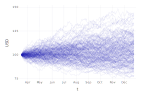

In [31]:
plot_paths(mcm,1:200)

In [32]:
value(mcm, eucall)

7.033411203103609USD

#### Asian Options

Asian options involve time-average prices, and can only really be evaluated using Monte Carlo.

In [33]:
# Asian fixed strike option based on average of the past month
asian = AsianFixedStrikeCall(Date("2017-12-25"), SingleStock(), Dates.Month(1), 100.00USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─MovingAveragePrice
    │  │  ├─SingleStock
    │  │  └─1 month
    │  └─Give
    │     └─Amount
    │        └─100.0USD
    └─Zero


In [34]:
value(mcm, asian)

6.727457283813901USD

## A peek under the hood

Although the models use very different algorithms, the core valuation is actually shared across all classes:

```julia
# Zero is worth, well, zero
@inline valueat(m::AbstractModel, c::Zero, state...) =
    0.0*numeraire(m) # numeriaire is the reference currency

# "Give" negates the value
@inline valueat(m::AbstractModel, c::Give, state...) =
    -valueat(m,c.c,state...)

# "Both" is the sum of the nested values
@inline valueat(m::AbstractModel, c::Both, state...) =
    valueat(m,c.c1,state...) + valueat(m,c.c2, state...)

# "Either" is the maximum of the nested values
@inline valueat(m::AbstractModel, c::Either, state...) =
    max(valueat(m,c.c1,state...), valueat(m,c.c2,state...))
```

What makes this possible is: 
1. Multiple dispatch and generic signatures allows one function to value different kinds of primitives,
2. Aggressive compiler optimisations generates efficient code comparable to the directly written version

### Currency Units

Miletus includes a currency unit type:

In [66]:
100.00USD + 20.00USD

120.0USD

* Captures important qualitative information
* Can catch certain errors of mismatched units
* No runtime overhead abstraction

In [67]:
100.00USD + 20.00GBP

LoadError: no promotion exists for Float64 and Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:GBP},Float64}

## Other features

### Volatility curve fitting

In [63]:
strikes = 46.50:0.50:48.50
contracts = [EuropeanCall(Date("2017-11-25"), SingleStock(), K) for K in strikes]
prices = [2.24,1.95,1.69,1.45,1.23]

core = CoreModel(Date("2017-11-01"), 47.32, 0.0, 0.0)

ivols = ivol.([core], contracts, prices)

5-element Array{Float64,1}:
 0.375322
 0.370226
 0.366849
 0.363018
 0.3587  

Can fit more complex models such as the SABR:

In [64]:
sabr = fit(SABRModel, core, contracts, prices)

Miletus.SABRModel{Float64}

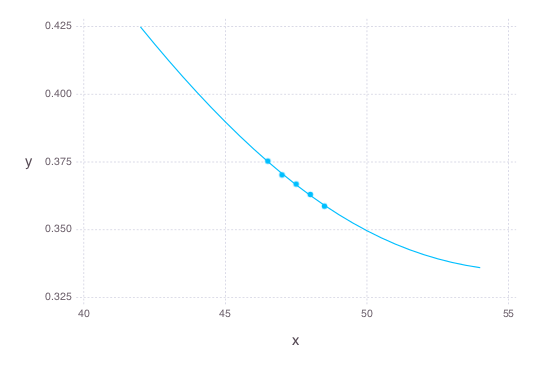

In [65]:
x_strikes = 42.00:0.50:54.00
xcontracts = [EuropeanCall(Date("2017-11-25"), SingleStock(), K) for K in x_strikes]

plot(
    layer(x=x_strikes, y=ivol.([sabr],xcontracts), Geom.line),
    layer(x=strikes, y=ivols, Geom.point))

## Greeks

Greeks are price senitivities: derivatives of the value of the contract with respect to a parameter of the model. With respect a portfolio, they capture the sensitivity of its value to model parameters. 

They're called Greeks because they're traditionally represented by Greek symbols.

Miletus makes wide use of _automatic differentiation_ (see www.juliadiff.org, or Jarrett's talk tomorrow).
 - more accurate than usual finite differencing techniques. 

In [38]:
# Derivative of the contract value wrt strike price
delta(m, eucall)

0.6162010305644144

In [39]:
# Derivative of the contract value wrt volatility
vega(m, eucall)

31.721630111302836USD

In [40]:
vega(mcm, eucall)  # using Monte Carlo model

31.694121385562752USD

In [41]:
vega(mcm, asian)    # vega of an Asian option

31.017771400189133USD

And more:
 - Stochastic volatility models
 - Pricing based on futures prices
 - Multiple exercise (swing) options

We also have lots more features planned:
 - Richer asset structure
 - Multifactor models
 - Support for exotic derivatives across currency, stock and commodities markets.

Try it out: www.juliacomputing.com/products/juliafin.html

Or get in touch: simon@juliacomputing.com / ranjan@juliacomputing.com

## Define your own contracts using these primitives

In [26]:
function butterfly_call(expiry::Date, K₁, K₂, K₃)
    @assert K₁ < K₂ < K₃
    c₁ = EuropeanCall(expiry, SingleStock(), K₁)
    c₂ = EuropeanCall(expiry, SingleStock(), K₂)
    c₃ = EuropeanCall(expiry, SingleStock(), K₃)
    Both(Both(c₁,c₃), Give(Both(c₂,c₂)))
end

butterfly_call (generic function with 1 method)

In [27]:
function payoff_curve(c, d::Date, prices)
    payoff = [value(GeomBMModel(d, x, 0.0, 0.0, 0.0), c) for x in prices] 
    p = [x.val for x in payoff]
    r = [x.val for x in prices]
    return r, p
end

payoff_curve (generic function with 1 method)

In [28]:
expirydate = Date("2017-12-25")
startdate  = Date("2017-12-1")
interestrate = 0.05
carryrate    = 0.1
volatility   = 0.15
K₁ = 98.0USD  
K₂ = 100.0USD
K₃ = 102.0USD
L  = 11 # Layers in the binomial lattice / Number of time steps
price = K₁-1USD:0.1USD:K₃+1USD

call₁ = EuropeanCall(expirydate, SingleStock(), K₁)
call₂ = EuropeanCall(expirydate, SingleStock(), K₂)
call₃ = EuropeanCall(expirydate, SingleStock(), K₃)
s₁,cp₁ = payoff_curve(call₁, expirydate, price)
s₂,cp₂ = payoff_curve(call₂, expirydate, price)
s₃,cp₃ = payoff_curve(call₃, expirydate, price)


([97.0,97.1,97.2,97.3,97.4,97.5,97.6,97.7,97.8,97.9  …  102.1,102.2,102.3,102.4,102.5,102.6,102.7,102.8,102.9,103.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

In [29]:
bfly₁ = butterfly_call(expirydate, K₁, K₂, K₃)

Both
 ├─Both
 │  ├─When
 │  │  ├─{==}
 │  │  │  ├─DateObs
 │  │  │  └─2017-12-25
 │  │  └─Either
 │  │     ├─Both
 │  │     │  ├─SingleStock
 │  │     │  └─Give
 │  │     │     └─Amount
 │  │     │        └─98.0USD
 │  │     └─Zero
 │  └─When
 │     ├─{==}
 │     │  ├─DateObs
 │     │  └─2017-12-25
 │     └─Either
 │        ├─Both
 │        │  ├─SingleStock
 │        │  └─Give
 │        │     └─Amount
 │        │        └─102.0USD
 │        └─Zero
 └─Give
    └─Both
       ├─When
       │  ├─{==}
       │  │  ├─DateObs
       │  │  └─2017-12-25
       │  └─Either
       │     ├─Both
       │     │  ├─SingleStock
       │     │  └─Give
       │     │     └─Amount
       │     │        └─100.0USD
       │     └─Zero
       └─When
          ├─{==}
          │  ├─DateObs
          │  └─2017-12-25
          └─Either
             ├─Both
             │  ├─SingleStock
             │  └─Give
             │     └─Amount
             │        └─100.0USD
             └─Zero


In [30]:
blk = colorant"black"
red = colorant"red"
grn = colorant"green"
blu = colorant"blue"
s,p_bfly₁ = payoff_curve(bfly₁, expirydate, price)


([97.0,97.1,97.2,97.3,97.4,97.5,97.6,97.7,97.8,97.9  …  102.1,102.2,102.3,102.4,102.5,102.6,102.7,102.8,102.9,103.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

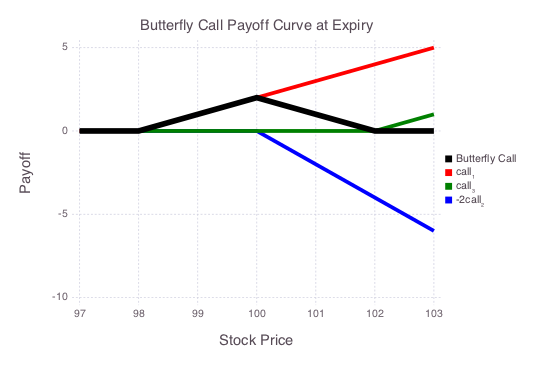

In [31]:
plot(layer( x=s ,y=p_bfly₁,Geom.line,Theme(default_color=blk,line_width=1.5mm)),
            layer( x=s₁,y=  cp₁  ,Geom.line,Theme(default_color=red,line_width=1.0mm)),
            layer( x=s₃,y=  cp₃  ,Geom.line,Theme(default_color=grn,line_width=1.0mm)),
            layer( x=s₂,y=-2cp₂  ,Geom.line,Theme(default_color=blu,line_width=1.0mm)),
            Guide.manual_color_key("",["Butterfly Call", "call₁", "call₃", "-2call₂"],
            ["black", "red", "green", "blue"]),
            Guide.title("Butterfly Call Payoff Curve at Expiry"),
            Guide.xlabel("Stock Price"), Guide.ylabel("Payoff"))

In [32]:
gbmm = GeomBMModel(startdate, K₂, interestrate, carryrate, volatility)
value(gbmm, bfly₁)

0.4024557323265583USD

In [34]:
# Buy a call at the high strike
# Sell a call at the low strike
function bear_call(expiry::Date, K₁, K₂)
    @assert K₁ != K₂
    c₁ = EuropeanCall(expiry, SingleStock(), K₁)
    c₂ = EuropeanCall(expiry, SingleStock(), K₂)
    Both(Give(c₁), c₂)
end


bear_call (generic function with 1 method)

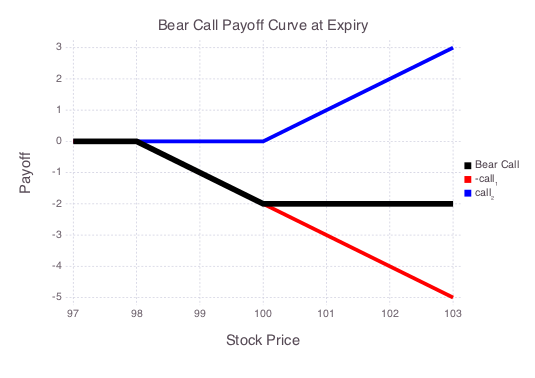

In [35]:
bear₁ = bear_call(expirydate, K₁, K₂)
s,p_bear₁ = payoff_curve(bear₁, expirydate, price)
blk = colorant"black"
red = colorant"red"
blu = colorant"blue"
plot(layer( x=s, y=p_bear₁,Geom.line,Theme(default_color=blk,line_width=1.5mm)),
     layer( x=s₁,y=-cp₁   ,Geom.line,Theme(default_color=red,line_width=1.0mm)),
     layer( x=s₂,y= cp₂   ,Geom.line,Theme(default_color=blu,line_width=1.0mm)),
     Guide.manual_color_key("",["Bear Call", "-call₁", "call₂"], 
     ["black", "red", "blue"]),
     Guide.title("Bear Call Payoff Curve at Expiry"), 
Guide.xlabel("Stock Price"), Guide.ylabel("Payoff"))

In [36]:
value(gbmm, bear₁)

-1.119680404537255USD

In [37]:
function couponbond(par,coupon,periods::Int,start::Date,expiry::Date)
    duration = expiry - start
    bond = When(AtObs(expiry), Receive(par))
    for p = periods-1:-1:1
        coupondate = start + duration*p/periods 
        bond = Both(bond,When(AtObs(coupondate), Receive(coupon)))
    end
    return bond
end

couponbond (generic function with 1 method)

In [38]:
par = 100USD
 coupon = 1USD
 periods = 12
 startdate = today()
expirydate = today() + Day(360)

2018-06-12

In [39]:
cpb = couponbond(par,coupon,periods,startdate,expirydate)

Both
 ├─Both
 │  ├─Both
 │  │  ├─Both
 │  │  │  ├─Both
 │  │  │  │  ├─Both
 │  │  │  │  │  ├─Both
 │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  │  │  │  ├─When
 │  │  │  │  │  │  │  │  │  │  │  ├─{==}
 │  │  │  │  │  │  │  │  │  │  │  │  ├─DateObs
 │  │  │  │  │  │  │  │  │  │  │  │  └─2018-06-12
 │  │  │  │  │  │  │  │  │  │  │  └─Amount
 │  │  │  │  │  │  │  │  │  │  │     └─100USD
 │  │  │  │  │  │  │  │  │  │  └─When
 │  │  │  │  │  │  │  │  │  │     ├─{==}
 │  │  │  │  │  │  │  │  │  │     │  ├─DateObs
 │  │  │  │  │  │  │  │  │  │     │  └─2018-05-13
 │  │  │  │  │  │  │  │  │  │     └─Amount
 │  │  │  │  │  │  │  │  │  │        └─1USD
 │  │  │  │  │  │  │  │  │  └─When
 │  │  │  │  │  │  │  │  │     ├─{==}
 │  │  │  │  │  │  │  │  │     │  ├─DateObs
 │  │  │  │  │  │  │  │  │     │  └─2018-04-13
 │  │  │  │  │  │  │  │  │     └─Amount
 │  │  │  │  │  │  │  │  │        └─1USD
 │  │  

In [45]:
value(ym, cpb)

101.08071610387296USD